# test_julia

test jupyter notebook for julia by transcribing script `../examples/basicBAMF.jl`

use [https://nbviewer.jupyter.org/](https://nbviewer.jupyter.org/) to view plotly interactive figures

In [2]:
# This cell has to be run 2x
using BayesMultiFit

In [3]:
BAMF=BayesMultiFit
using ReversibleJumpMCMC
const RJMCMC = ReversibleJumpMCMC
using ImageView
using Plots
using Distributions
using MATLAB

In [4]:
## simulation config
n=Int32(6)      # number of emitters
μ=1000          # mean photons per emitter               
sz=Int32(16)    # ROI size in pixels
iterations=5000 # RJMCMC iterations
burnin=5000     # RJMCMC iterations for burn-in

## PSF config
σ=1.3f0 # Gaussian PSF Sigma in Pixels
psf=BAMF.PSF_gauss2D(σ)

Error: Direct kernel connection broken

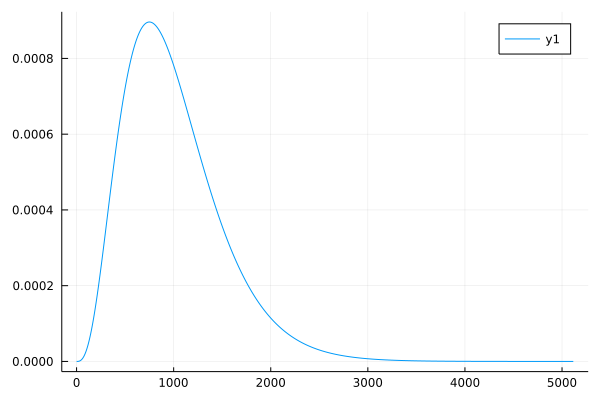

BayesMultiFit.RJPrior(1024, 1.0f0, 5.0f0, Float32[4.249634f-11, 8.997448f-9, 5.4344774f-8, 1.6392825f-7, 3.633004f-7, 6.7583727f-7, 1.1228487f-6, 1.7236846f-6, 2.4958356f-6, 3.4550314f-6  …  8.63257f-9, 8.486683f-9, 8.343255f-9, 8.20221f-9, 8.063527f-9, 7.927165f-9, 7.793102f-9, 7.661269f-9, 7.531645f-9, 7.404193f-9])

In [5]:
## setup prior distribution on intensity
α=Float32(4)
θ=Float32(μ/α)
g=Gamma(α,θ)
len=Int32(1024)
θ_start=Float32(1)
θ_step=Float32(5.0)
pdf_x=range(θ_start,step=θ_step,length=len)
mypdf=pdf(g,pdf_x)
plt=plot(pdf_x,mypdf)
display(plt)
prior_photons=BAMF.RJPrior(len,θ_start,θ_step,mypdf)

In [6]:
# set emitter positions and intensity
x=sz/2f0*ones(Float32,n)+3*σ*randn(Float32,n)
y=sz/2f0*ones(Float32,n)+ 3*σ*randn(Float32,n)
photons=Float32.(rand(g,n))
bg=1f-6
datastate=BAMF.StateFlatBg(n,x,y,photons,bg)

## Create synthetic data
data=BAMF.ArrayDD(sz)      
BAMF.genmodel!(datastate,psf,data)
BAMF.poissrnd!(data.data)
# imshow(data.data)  #look at data  

## create a BAMF-type RJMCMC structure
xystd=σ/10
istd=10f0
split_std=σ
bndpixels=0f0
myRJ=BAMF.RJStruct(sz,psf,xystd,istd,split_std,data,bndpixels,prior_photons)

## setup the RJMCMC.jl model
# Jumptypes are: move, bg, add, remove, split, merge
njumptypes=6
jumpprobability=[1,0,.1,.1,.1,.1] # Model with no bg 
jumpprobability=jumpprobability/sum(jumpprobability)

# create an RJMCMC structure with all model info
acceptfuns=[BAMF.accept_move,BAMF.accept_bg,BAMF.accept_add,BAMF.accept_remove,BAMF.accept_split,BAMF.accept_merge] #array of functions
propfuns=[BAMF.propose_move,BAMF.propose_bg,BAMF.propose_add,BAMF.propose_remove,BAMF.propose_split,BAMF.propose_merge] #array of functions
myRJMCMC=RJMCMC.RJMCMCStruct(burnin,iterations,njumptypes,jumpprobability,propfuns,acceptfuns)

#create an intial state
state1=BAMF.calcintialstate(myRJ)

## run chain. This is the call to the main algorithm
@time mychain=RJMCMC.buildchain(myRJMCMC,myRJ,state1)

## Display
plotly()
zm=Int32(4)
plt=BAMF.histogram2D(mychain.states,sz,zm,datastate)
display(plt)

  2.269784 seconds (2.37 M allocations: 140.702 MiB, 2.06% gc time)


<!DOCTYPE html>
 
 
 Plots.jl

┌ Info: For saving to png with the Plotly backend PlotlyBase has to be installed.
└ @ Plots /home/pcutler/.julia/packages/Plots/zd6zi/src/backends.jl:372


In [7]:
map_n,posterior_n,traj_n=BAMF.getn(mychain.states)
plt2=plot(traj_n)
display(plt2)
BAMF.showoverlay(mychain.states,myRJ)

## MAPN Results
states_mapn,n=BAMF.getmapnstates(mychain.states)
plt=BAMF.histogram2D(states_mapn,sz,zm,datastate)
display(plt)

Results_mapn=BAMF.getmapn(mychain.states)
BAMF.plotstate(datastate,Results_mapn)


## Teting the matlab interface

out=BAMF.matlab_DD_FlatBG(data.data,"gauss",1.3f0,θ_start,θ_step,len,mypdf,Int32(burnin),Int32(iterations),xystd,istd,split_std,bndpixels)

# mex interface

args=[MATLAB.mxarray(data.data),
MATLAB.mxarray("gauss"),MATLAB.mxarray(1.3f0),MATLAB.mxarray(θ_start),MATLAB.mxarray(θ_step),
MATLAB.mxarray(len),MATLAB.mxarray(mypdf),MATLAB.mxarray(Int32(burnin)),MATLAB.mxarray(Int32(iterations)),
MATLAB.mxarray(xystd),MATLAB.mxarray(istd),MATLAB.mxarray(split_std),MATLAB.mxarray(bndpixels)
]

BAMF.mextypes(args)
BAMF.mextest(args)

mapn=BAMF.matlab_DD_FlatBG_mex(args)

@time mapn=BAMF.matlab_DD_FlatBG_mex_lite(args);

<!DOCTYPE html>
 
 
 Plots.jl

(16, 16, 5000)
BayesMultiFit.StateFlatBg_CPU(6, Float32[11.268372, 10.341027, 3.9208782, 9.421751, 18.53561, 8.5385275], Float32[4.4907618, 7.119417, 12.671101, 8.794146, 9.412082, 7.531062], Float32[2395.069, 1347.4232, 1077.9551, 811.31976, 36.319828, 1128.1846], 0.0f0)
(